# Using Gillespie Algorithm + Neufit to Create graphics for Fig 4 
- Code based off of @author: Roman Zapien-Campos - 2021 and corresponding Selection paper

a). Looking at different rareifaction to see how effects curve  
b). Summing across df to ensure mean realtive abduance actually is ~1

In [1]:
import numpy as np
import pandas as pd
from biom import load_table

#Neufit 
from lmfit import Parameters, Model, fit_report
from scipy.stats import beta
from statsmodels.stats.proportion import proportion_confint
from matplotlib import pyplot
from math import log10

#Selection
from numpy import genfromtxt
from datetime import datetime

## Functions

### Neufit Functions

In [2]:
def calc_abdundance(biom_df, ignore_level):
    abundances = biom_df[biom_df.sum(1) > ignore_level]
    print ('dataset contains ' + str(abundances.shape[1]) + ' samples (sample_id, reads):')
    print (abundances.sum(0), '\n')
    return(abundances)

In [3]:
def subsample(counts, depth):
    # Subsamples counts to uniform depth, dropping all samples without enough depth
    for sample in counts:
        if counts[sample].sum() >= depth:
            flattened = np.repeat(np.arange(counts[sample].size), counts[sample])
            subsample = np.random.choice(flattened, depth, replace=False)
            counts[sample] = np.bincount(subsample, minlength=counts[sample].size)
        else:
            print ('dropping sample ' + sample + ' with ' + str(counts[sample].sum()) + ' reads < ' + str(depth))
            counts = counts.drop(sample, axis=1)
    return counts

In [4]:
def rarefraction(biom_df, ignore_level, rarefaction_level):
    abundances = calc_abdundance(biom_df, ignore_level)
    
    if rarefaction_level == 0 or rarefaction_level > max(abundances.sum(0)):
        rarefaction_level = min(abundances.sum(0))
        print('rarefying to highest possible uniform read depth')
    else:
        print ('rarefying to custom rarefaction level')
    print ('(' + str(rarefaction_level) + ' reads per sample)')
    
    if not all(n_reads == rarefaction_level for n_reads in abundances.sum(0)):
        abundances = subsample(abundances, rarefaction_level)
        abundances = abundances[abundances.sum(1) > 0]
        
    n_otus, n_samples = abundances.shape
    n_reads = rarefaction_level

    print ('\nfitting neutral expectation to dataset with ' + str(n_samples) + ' samples and ' + str(n_otus) + ' otus')
    
    return(abundances, n_samples, n_reads)

In [5]:
def add_taxonomy(occurr_freqs, taxonomy_file = 'neufit_inputs/lineages.txt'):
    taxonomy = pd.read_table(taxonomy_file, header=0, index_col=0, sep='\t')
    taxonomy.index.name = 'otu_id'
    occurr_freqs = occurr_freqs.join(taxonomy)
    return(occurr_freqs)

In [6]:
def calc_mean_realtive_abudnace(abundances, n_samples, n_reads, rarefaction_level, add_tax=False):
    
    mean_relative_abundance = (1.0*abundances.sum(1))/n_reads/n_samples
    occurrence_frequency = (1.0*np.count_nonzero(abundances, axis=1))/n_samples

    occurr_freqs = pd.DataFrame(mean_relative_abundance, columns=['mean_abundance'])
    occurr_freqs['occurrence'] = occurrence_frequency
    #occurr_freqs.index.name = 'otu_id'
    
    occurr_freqs = occurr_freqs.sort_values(by=['mean_abundance'])
    
    '''
    #Move H.pylori to top row of dataframe
    occurr_freqs['hp'] = range(1,len(occurr_freqs)+1)
    occurr_freqs.loc['k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter pylori', 'hp']=0
    occurr_freqs = occurr_freqs.sort_values('hp').drop('hp', axis = 1)
    '''
    
    if add_tax == True:
        occurr_freqs = add_taxonomy(occurr_freqs)
        
    #mean_abundance_list_fn = 'HutchBE_q' + biom_featureTable_fn.split('/')[1].split('_')[1] + '_' + biom_featureTable_fn.split('/')[2].split('.biom')[0] + '_' + time_date() + '_' + str(n_samples) + '_' + str(len(occurr_freqs)) + '_' + str(rarefaction_level) 
    mean_abundance_list_fn = 'None'
    
    return(occurr_freqs, mean_abundance_list_fn)

In [7]:
def beta_cdf(p, N, m):
    # Expected long term distribution under the neutral model (truncated cumulative beta-distribution)
    return beta.cdf(1.0, N*m*p, N*m*(1.0-p)) - beta.cdf(1.0/N, N*m*p, N*m*(1.0-p))

In [8]:
def neufit_calc(occurr_freqs, n_reads, n_samples, print_non_netural=False, print_report=True):
    
    #Fit the model
    params = Parameters()
    params.add('N', value=n_reads, vary=False)
    params.add('m', value=0.5, min=0.0, max=1.0)
    beta_model = Model(beta_cdf)
    beta_fit = beta_model.fit(occurr_freqs['occurrence'], params, p=occurr_freqs['mean_abundance'])
    
    r_square = 1.0 - np.sum(np.square(occurr_freqs['occurrence'] - beta_fit.best_fit))/np.sum(np.square(occurr_freqs['occurrence'] - np.mean(occurr_freqs['occurrence'])))
    
    if print_report == True:
        print(fit_report(beta_fit))
        print ('R^2 = ' + '{:1.2f}'.format(r_square))
    
    occurr_freqs['predicted_occurrence'] = beta_fit.best_fit
    occurr_freqs['lower_conf_int'], occurr_freqs['upper_conf_int'] = proportion_confint(occurr_freqs['predicted_occurrence']*n_samples, n_samples, alpha=0.05, method='wilson')
    
    if print_non_netural == True:
        above = occurr_freqs[occurr_freqs['occurrence'] > occurr_freqs['upper_conf_int']]
        below = occurr_freqs[occurr_freqs['occurrence'] < occurr_freqs['lower_conf_int']]
        print('Above uppper conf interval:', above)
        print()
        print('Below lower conf interval', below)
        
    return(beta_fit, r_square)

In [9]:
def neufit_plot(occurr_freqs, beta_fit, n_samples, n_reads, r_square, HP_color = False, save_plot=False):
    pyplot.cla() #Clears previous plot - to avoid double keys

    #Prepare results plot
    pyplot.xlabel('Mean relative abundance across samples', fontsize=18)
    pyplot.xscale('log')
    x_range = np.logspace(log10(min(occurr_freqs['mean_abundance'])/10), 0, 1000)
    pyplot.xlim(min(x_range), max(x_range))
    pyplot.xticks(fontsize=16)
    pyplot.ylabel('Occurrence frequency in samples', fontsize=18)
    pyplot.ylim(-0.05, 1.05)
    pyplot.yticks(fontsize=16)

    #>>Calculate lower and upper range
    lower, upper = proportion_confint(beta_cdf(x_range, n_reads, beta_fit.best_values['m'])*n_samples, n_samples, alpha=0.05, method='wilson')

    #>>Calculate/plot the main fit line
    #Orginal plotting colors
    pyplot.plot(x_range, beta_cdf(x_range, n_reads, beta_fit.best_values['m']), '-', lw=5, color='orange')
    pyplot.plot(x_range, lower, '--', lw=2, color='orange')
    pyplot.plot(x_range, upper, '--', lw=2, color='orange')
    pyplot.fill_between(x_range, lower, upper, color='lightgrey')

    # Plot data points
    pyplot.plot(occurr_freqs['mean_abundance'], occurr_freqs['occurrence'], 'o', markersize=1, fillstyle='full', color='black')
    
    #Extract m value
    m = fit_report(beta_fit).split('(fixed)')[1]
    m = 'm = ' + str(round(float(m.strip('\n').split('+')[0].strip(' ').strip('m: ')),3))

    #Plot R^2 and m values
    pyplot.text(0.05, 0.9, m, fontsize=16, transform=pyplot.gca().transAxes)
    pyplot.text(0.05, 0.8, '$R^2 = ' + '{:1.2f}'.format(r_square) + '$', fontsize=16, transform=pyplot.gca().transAxes)
    
    ''''
    if HP_color != False:
        hp_occurr_freqs = occurr_freqs.loc['k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter pylori' , :]
        pyplot.plot(hp_occurr_freqs['mean_abundance'], hp_occurr_freqs['occurrence'], 'o', markersize=6, fillstyle='full', color='magenta')
    '''
    
    if save_plot != False:
        #Save plot
        pyplot.tight_layout()
        pyplot.gcf().set_size_inches(10, 5)
        pyplot.savefig(save_plot)
        #pyplot.savefig('neufit_outputs/' + save_plot + '.png')
        
        #Save df
        #occurr_freqs.to_csv('neufit_outputs/' + save_plot + '.tsv', sep='\t')

    pyplot.show()

### Selection Functions

In [10]:
def time_date():
    
    time = datetime.time(datetime.now())
    date = datetime.date(datetime.now())
    h,s = str(time).split(".") #Split  the string into  hours/min and seconds
    h = h.replace(':','-')
    
    return(str(date) + '_' + str(h))

In [11]:
def selection_plot(selection_output, save_plot=False, HP_color = True):
    
    #Extract useful info out of title
    n_reads = int(selection_output.split('_n')[0].split('_')[-1])
    n_samples = int(selection_output.split('_n')[0].split('_')[-3])
    m_value = int(selection_output.split('_m')[1].split('.')[0])
    neutrality = 'N' + str(selection_output.split('_n')[1].split('_')[0])
    if neutrality == 'Non':
        neutrality = 'Non-Neutral'
    
    #Re-creating inputs needed for base of neufit plot
    occurr_freqs = pd.read_csv('neufit_outputs/' + selection_output.split('_n')[0] + '.tsv', sep='\t', index_col=0)
    beta_fit, r_square = neufit_calc(occurr_freqs, n_reads, n_samples, print_report=False)

    ###Selection Plotting###
    pyplot.cla() #Clears previous plot - to avoid double keys
    
    #Create identical plot to Neufit above
    pyplot.xlabel('Mean relative abundance across samples', fontsize=18)
    pyplot.xscale('log')
    x_range = np.logspace(log10(min(occurr_freqs['mean_abundance'])/10), 0, 1000)
    pyplot.xlim(min(x_range), max(x_range))
    pyplot.xticks(fontsize=16)
    pyplot.ylabel('Occurrence frequency in samples', fontsize=18)
    pyplot.ylim(-0.05, 1.05)
    pyplot.yticks(fontsize=16)
        
    #Import and plot selection data
    selection_data = np.load('selection_outputs/' + str(selection_output))
    pyplot.plot(selection_data['mean_freq_nneutral'], selection_data['P0_nneutral'], 'o', markersize=6, fillstyle='full', color = 'black')
                    
    #Caclulating the R^2 value of the simulation data fit to the orginal neufit red line plotted above
    r_square_gillespie = 1.0 - np.sum(np.square(selection_data['P0_nneutral'] - beta_fit.best_fit))/np.sum(np.square(selection_data['P0_nneutral'] - np.mean(selection_data['P0_nneutral'])))
    
    #Add m value from gillespie sim & r^2 value of sim data fit to neufit line to plot
    pyplot.text(0.05, 1.1, 'Gillespie Simulation : ' + neutrality, fontsize=16, transform=pyplot.gca().transAxes)
    pyplot.text(0.05, 0.9, 'm = ' + str(m_value), fontsize=16, transform=pyplot.gca().transAxes)
    pyplot.text(0.05, 0.8, '$R^2 = ' + '{:1.2f}'.format(r_square_gillespie) + '$', fontsize=16, transform=pyplot.gca().transAxes)
    
    #>>Calculate lower and upper range (from Neufit above)
    lower, upper = proportion_confint(beta_cdf(x_range, n_reads, beta_fit.best_values['m'])*n_samples, n_samples, alpha=0.05, method='wilson')

    #>>Calculate/plot the main fit line (from Neufit above)
    pyplot.plot(x_range, beta_cdf(x_range, n_reads, beta_fit.best_values['m']), '-', lw=5, color='darkred')
    pyplot.plot(x_range, lower, '--', lw=2, color='darkred')
    pyplot.plot(x_range, upper, '--', lw=2, color='darkred')
    pyplot.fill_between(x_range, lower, upper, color='lightgrey')
    
    if HP_color != False:
        #Create color array (for h.pylori to stand out)
        color_array = ['#4778F7'] * len(selection_data['mean_freq_nneutral'])
        color_array[0] = '#f7477f'
        
        pyplot.plot(selection_data['mean_freq_nneutral'][0], selection_data['P0_nneutral'][0], 'o', markersize=6, fillstyle='full', color='magenta')

    if save_plot != False:
        #Save plot
        pyplot.tight_layout()
        pyplot.savefig('selection_outputs/' + selection_output.split('.npz')[0] + '.png')
    
    pyplot.show()


## Neufit 

#### Import Data for Neufit (Neutral Simulation)

##### AGP (American Gut project)

In [21]:
#Import biom table from Qiita and convert to pandas df
biom_featureTable_fn = '/Users/cguccion/Dropbox/Storage/RawData/01_11_2021_Hutch340_BE_Samples_LudmilAlexandrov/woltka_tissue/WOL2/wol2_none.biom' 
biom_featureTable = load_table(biom_featureTable_fn)

biom_df = pd.DataFrame(biom_featureTable.matrix_data.toarray(), biom_featureTable.ids('observation'), biom_featureTable.ids())

#Import Source biom table from Qiita and convert to pandas df

#Source table from AGP (wol2): 

#Mouth
#sbiom_featureTable_fn = '/Users/cguccion/Dropbox/Storage/RawData/23_03_22_AmericanGutProject/metagenomic_prep_AG88/subset_AGP/agp_AG88_mouth/agp_AG88_mouth_genome.tsv' 

#Fecal
sbiom_featureTable_fn = '/Users/cguccion/Dropbox/Storage/RawData/23_03_22_AmericanGutProject/metagenomic_prep_AG88/subset_AGP/agp_AG88_feces/agp_AG88_feces_genome.tsv' 

sbiom_df = pd.read_csv(sbiom_featureTable_fn, sep = '\t', index_col = 0)

#Import metadata and convert datatype to match biom_df
meta = pd.read_csv('neufit_inputs/340_BE_samples_cleanMeta.csv')
meta['SampleName'] = meta['SampleName'].apply(lambda x: str(x).replace('-', '.'))
#display(meta[:3])

#Import taxonomy file
#taxonomy_file = 'Users/cguccion/Dropbox/Storage/HelpfulLabDocs/taxonomy_trees/RS210/RS210.tax'

ignore_level = 0
rarefaction_level = 5000



##### HMP (Human Microbiome Project) : Caitlin Download

In [26]:
#Import biom table from Qiita and convert to pandas df
biom_featureTable_fn = '/Users/cguccion/Dropbox/Storage/RawData/01_11_2021_Hutch340_BE_Samples_LudmilAlexandrov/woltka_tissue/RS210/rs210_none.biom' 
biom_featureTable = load_table(biom_featureTable_fn)

biom_df = pd.DataFrame(biom_featureTable.matrix_data.toarray(), biom_featureTable.ids('observation'), biom_featureTable.ids())

#Import Source biom table from Qiita and convert to pandas df

#Source table from HMP
sbiom_featureTable_fn = '/Users/cguccion/Downloads/168735_none.biom' 
sbiom_featureTable = load_table(sbiom_featureTable_fn)
sbiom_df = pd.DataFrame(sbiom_featureTable.matrix_data.toarray(), sbiom_featureTable.ids('observation'), sbiom_featureTable.ids())

#Import metadata and convert datatype to match biom_df
meta = pd.read_csv('neufit_inputs/340_BE_samples_cleanMeta.csv')
meta['SampleName'] = meta['SampleName'].apply(lambda x: str(x).replace('-', '.'))
#display(meta[:3])

#Import taxonomy file
taxonomy_file = 'Users/cguccion/Dropbox/Storage/HelpfulLabDocs/taxonomy_trees/RS210/RS210.tax'

ignore_level = 0
rarefaction_level = 5000


In [25]:
#Subset the biom table into two groups?

#display(sbiom_df[:2])

meta = pd.read_csv('sample_information_from_prep_14506.tsv', sep = '\t')
#display(meta)

meta_saliva = meta[meta.bodysite.isin(['Saliva'])]
sbiom_saliva_df = sbiom_df[sbiom_df.columns.intersection(meta_saliva['sample_name'].tolist())]
#display(sbiom_saliva_df)

meta_throat = meta[meta.bodysite.isin(['Throat'])]
sbiom_throat_df = sbiom_df[sbiom_df.columns.intersection(meta_throat['sample_name'].tolist())]
#sbiom_throat_df

sbiom_df = sbiom_saliva_df

##### HMP (Human Microbiome Project) : Qiita #1926 Download

In [14]:
hmp_meta = pd.read_csv('/Users/cguccion/Dropbox/Storage/RawData/23_03_04_HumanMicrobiomeProjectDataPortal/qiita_1926_bioms/sampleInfo_1926_20230206-074243.txt', sep = '\t')
display(hmp_meta.bodysite.value_counts())

Stool                           553
Tongue_dorsum                   425
Supragingival_plaque            398
Buccal_mucosa                   378
Anterior_nares                  269
Posterior_fornix                209
R_Retroauricular_crease          32
Palatine_Tonsils                 25
L_Retroauricular_crease          24
Subgingival_plaque               24
Throat                           18
Attached_Keratinized_gingiva     17
Mid_vagina                       14
Vaginal_introitus                11
Saliva                            8
R_Antecubital_fossa               1
Hard_palate                       1
Name: bodysite, dtype: int64

In [13]:
def subset_HMP_sample_type(df, bodySite):
    #Subset HMP biom table to just contain particular body site
    
    hmp_meta = pd.read_csv('/Users/cguccion/Dropbox/Storage/RawData/23_03_04_HumanMicrobiomeProjectDataPortal/qiita_1926_bioms/sampleInfo_1926_20230206-074243.txt', sep = '\t')
    display(hmp_meta.bodysite.value_counts())
    
    #Create custom meta
    meta_custom =  hmp_meta[(hmp_meta.bodysite == bodySite)]
    
    #Subset df to only contain items in meta_custom
    df_custom = df[df.columns.intersection(meta_custom['sample_name'].tolist())]
    
    return(df_custom)

###### WoL2 

In [80]:
store_tounge_sab_10000000 = sab.copy()
store_tounge_sn_samples = sn_samples
store_tounge_sn_reads = sn_reads

In [25]:
#-----------Sink

#All BE Tissue Sample
biom_featureTable_fn = '/Users/cguccion/Dropbox/Storage/RawData/01_11_2021_Hutch340_BE_Samples_LudmilAlexandrov/woltka_tissue/WOL2/wol2_none.biom' 
biom_featureTable = load_table(biom_featureTable_fn)
biom_df = pd.DataFrame(biom_featureTable.matrix_data.toarray(), biom_featureTable.ids('observation'), biom_featureTable.ids())

#-----------Source 

#Import all source biom tables from Qiita and conver to pandas df
oral_s1_table = load_table('/Users/cguccion/Dropbox/Storage/RawData/23_03_04_HumanMicrobiomeProjectDataPortal/qiita_1926_bioms/WoL2/oral_set1_WoL2_160176_none.biom') 
oral_s1_df = pd.DataFrame(oral_s1_table.matrix_data.toarray(), oral_s1_table.ids('observation'), oral_s1_table.ids())

oral_s2_table = load_table('/Users/cguccion/Dropbox/Storage/RawData/23_03_04_HumanMicrobiomeProjectDataPortal/qiita_1926_bioms/WoL2/oral_set2_WoL2_170864_none.biom') 
oral_s2_df = pd.DataFrame(oral_s2_table.matrix_data.toarray(), oral_s2_table.ids('observation'), oral_s2_table.ids())

oral_s3_table = load_table('/Users/cguccion/Dropbox/Storage/RawData/23_03_04_HumanMicrobiomeProjectDataPortal/qiita_1926_bioms/WoL2/oral_set3_WoL2_160422_none.biom') 
oral_s3_df = pd.DataFrame(oral_s3_table.matrix_data.toarray(), oral_s3_table.ids('observation'), oral_s3_table.ids())

oral_s4_table = load_table('/Users/cguccion/Dropbox/Storage/RawData/23_03_04_HumanMicrobiomeProjectDataPortal/qiita_1926_bioms/WoL2/oral_set4_WoL2_160417_none.biom') 
oral_s4_df = pd.DataFrame(oral_s4_table.matrix_data.toarray(), oral_s4_table.ids('observation'), oral_s4_table.ids())

#Combine all biom tables
oral_wol2_df = pd.concat([oral_s1_df, oral_s2_df, oral_s3_df, oral_s4_df], axis = 1).fillna(0)

'''
#Split biom tables into diease type
tounge_wol2_df = subset_HMP_sample_type(oral_wol2_df, 'Tongue_dorsum')
mucosa_wol2_df = subset_HMP_sample_type(oral_wol2_df, 'Buccal_mucosa')


#Fecal
fecal_biom_featureTable_fn = '/Users/cguccion/Dropbox/Storage/RawData/23_03_22_AmericanGutProject/metagenomic_prep_AG88/subset_AGP/agp_AG88_feces/agp_AG88_feces_genome.tsv' 
fecal_biom_df = pd.read_csv(fecal_biom_featureTable_fn, sep = '\t', index_col = 0)
fecal_mucosa_wol2_df = pd.concat([fecal_biom_df, mucosa_wol2_df], axis = 1).fillna(0)
'''
#-----------Additional Info
#Import taxonomy file
taxonomy_file = '/Users/cguccion/Dropbox/Storage/HelpfulLabDocs/taxonomy_trees/WOL2/lineages.txt'

ignore_level = 0
sink_rarefaction_level = 5000
source_rarefaction_level = 10000 #500000

#sbiom_df = fecal_mucosa_wol2_df
sbiom_df = oral_wol2_df

#### Check HP

In [54]:
tounge_wol2_df

,1926.SRS015395,1926.SRS014404,1926.SRS011140,1926.SRS015174,1926.SRS011243,1926.SRS015686,1926.SRS014528,1926.SRS014573,1926.SRS014935,1926.SRS015038,...,1926.SRS893324,1926.SRS893363,1926.SRS893365,1926.SRS893371,1926.SRS893377,1926.SRS893348,1926.SRS893352,1926.SRS893353,1926.SRS893350,1926.SRS893359
G000005825,63.0,5.0,37.0,31.0,23.0,9.0,4.0,29.0,22.0,19.0,...,9.0,13.0,16.0,13.0,14.0,14.0,18.0,13.0,42.0,7.0
G000006605,93.0,9.0,28.0,1039.0,74.0,427.0,2381.0,137.0,507.0,56.0,...,106.0,43.0,865.0,235.0,254.0,45.0,102.0,505.0,345.0,153.0
G000006725,0.0,1.0,4.0,2.0,5.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,8.0,0.0
G000006745,5.0,19.0,51.0,39.0,138.0,7.0,4.0,51.0,8.0,3.0,...,6.0,12.0,2.0,6.0,8.0,4.0,3.0,5.0,103.0,9.0
G000006785,8814.0,933.0,4610.0,3300.0,1665.0,769.0,351.0,2711.0,2173.0,1084.0,...,1249.0,1257.0,2001.0,1329.0,2008.0,1245.0,1830.0,1484.0,5063.0,682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G900079125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G902158745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G902515475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G902551155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
def check_HP(df):
    hp_total = sum(list(df.loc['G000274045',:])) + sum(list(df.loc['G000274085',:])) + sum(list(df.loc['G000274945',:])) + sum(list(df.loc['G000740095',:]))
    print('hp_total', hp_total)
    print('hp_fraction', hp_total/df.values.sum())

In [ ]:
check_HP(tounge_wol2_df)

check_HP(mucosa_wol2_df)

In [20]:
check_HP(oral_wol2_df)

hp_total 148563.0
hp_fraction 5.865585745124691e-06


In [28]:
oral_wol2_df

,1926.SRS015395,1926.SRS014404,1926.SRS014686,1926.SRS011140,1926.SRS015174,1926.SRS015062,1926.SRS011243,1926.SRS013663,1926.SRS015686,1926.SRS016088,...,1926.SRS893374,1926.SRS893371,1926.SRS893377,1926.SRS893348,1926.SRS893352,1926.SRS893353,1926.SRS893354,1926.SRS893350,1926.SRS893355,1926.SRS893359
G000005825,63.0,5.0,3.0,37.0,31.0,0.0,23.0,1.0,9.0,0.0,...,1.0,13.0,14.0,14.0,18.0,13.0,0.0,42.0,1.0,7.0
G000006605,93.0,9.0,8.0,28.0,1039.0,2.0,74.0,40.0,427.0,2.0,...,81.0,235.0,254.0,45.0,102.0,505.0,3.0,345.0,237.0,153.0
G000006725,0.0,1.0,1.0,4.0,2.0,0.0,5.0,1.0,0.0,0.0,...,5.0,1.0,1.0,0.0,0.0,0.0,5.0,8.0,3.0,0.0
G000006745,5.0,19.0,3.0,51.0,39.0,0.0,138.0,5.0,7.0,1.0,...,5.0,6.0,8.0,4.0,3.0,5.0,1.0,103.0,4.0,9.0
G000006785,8814.0,933.0,401.0,4610.0,3300.0,18.0,1665.0,55.0,769.0,54.0,...,84.0,1329.0,2008.0,1245.0,1830.0,1484.0,119.0,5063.0,211.0,682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G900079125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G902158745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G902515475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G902551155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Import data and calculate rarefraction

In [26]:
store_ = sab.copy()
store__sn_samples = sn_samples
store__sn_reads = sn_reads

NameError: name 'sab' is not defined

In [24]:
ab, n_samples, n_reads = rarefraction(biom_df, ignore_level, sink_rarefaction_level)

dataset contains 336 samples (sample_id, reads):
PCGA-1127-BE-04     63517.0
PCGA-1068-BE-06     78599.0
PCGA-1140-BE-02     93588.0
PCGA-1086-BE-03     92265.0
PCGA-1092-BE-01    125488.0
                     ...   
PCGA-1075-BE-01    128279.0
PCGA-1098-BE-03    133898.0
PCGA-1118-BE-01    103746.0
PCGA-1073-BE-03     85580.0
PCGA-1105-BE-01     64730.0
Length: 336, dtype: float64 

rarefying to custom rarefaction level
(5000 reads per sample)
dropping sample PCGA-1074-BE-03 with 2539.0 reads < 5000
dropping sample PCGA-1091-BE-01 with 2461.0 reads < 5000
dropping sample PCGA-1078-BE-01 with 3426.0 reads < 5000
dropping sample PCGA-1129-BE-02 with 1394.0 reads < 5000
dropping sample PCGA-1132-BE-02 with 1883.0 reads < 5000

fitting neutral expectation to dataset with 331 samples and 1001 otus


In [27]:
sab, sn_samples, sn_reads = rarefraction(sbiom_df, ignore_level, source_rarefaction_level)

dataset contains 1291 samples (sample_id, reads):
1926.SRS015395    32548929.0
1926.SRS014404    21179824.0
1926.SRS014686     2651384.0
1926.SRS011140    29730100.0
1926.SRS015174    45227831.0
                     ...    
1926.SRS893353    18630713.0
1926.SRS893354     2234205.0
1926.SRS893350    50207063.0
1926.SRS893355    18000530.0
1926.SRS893359    12105215.0
Length: 1291, dtype: float64 

rarefying to custom rarefaction level
(10000 reads per sample)
dropping sample 1926.SRS013976 with 6916.0 reads < 10000
dropping sample 1926.SRS150038 with 4416.0 reads < 10000

fitting neutral expectation to dataset with 1289 samples and 6736 otus


### Calculate mean realaitve abduance

In [101]:
occurr_freqs, mean_abundance_list_fn = calc_mean_realtive_abudnace(ab, n_samples, n_reads, sink_rarefaction_level) #, True)
display(occurr_freqs)

,mean_abundance,occurrence
G000299335,6.042296e-07,0.003021
G000382345,6.042296e-07,0.003021
G000382305,6.042296e-07,0.003021
G000381025,6.042296e-07,0.003021
G001425865,6.042296e-07,0.003021
...,...,...
G900172375,1.250211e-02,1.000000
G001049355,1.284109e-02,1.000000
G001404055,1.286284e-02,1.000000
G001748365,1.346888e-02,1.000000


In [102]:
soccurr_freqs, smean_abundance_list_fn = calc_mean_realtive_abudnace(sab, sn_samples, sn_reads, source_rarefaction_level) #, True)
display(soccurr_freqs)

,mean_abundance,occurrence
G001463995,1.396648e-07,0.001397
G003315135,1.396648e-07,0.001397
G000212335,1.396648e-07,0.001397
G000737985,1.396648e-07,0.001397
G000739085,1.396648e-07,0.001397
...,...,...
G001055885,2.411020e-02,0.675978
G001719865,2.875726e-02,0.568436
G001133125,3.009316e-02,0.571229
G000154205,3.654190e-02,0.775140


In [103]:
#display(soccurr_freqs['mean_abundance'])
#display(occurr_freqs['occurrence'])

combo = pd.concat([soccurr_freqs['mean_abundance'], occurr_freqs['occurrence']], axis =1, join='inner')
combo

,mean_abundance,occurrence
G001705225,1.396648e-07,0.009063
G000746525,1.396648e-07,0.006042
G000747155,1.396648e-07,0.006042
G000751295,1.396648e-07,0.114804
G003345355,1.396648e-07,0.117825
...,...,...
G000261285,2.142612e-02,0.102719
G001055885,2.411020e-02,0.081571
G001719865,2.875726e-02,0.145015
G001133125,3.009316e-02,0.129909


### Neufit Caluclation & Plotting

In [104]:
beta_fit, r_square = neufit_calc(combo, n_reads, n_samples)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 869
    # variables        = 1
    chi-square         = 79.1454409
    reduced chi-square = 0.09118138
    Akaike info crit   = -2080.17261
    Bayesian info crit = -2075.40527
[[Variables]]
    N:  5000 (fixed)
    m:  1.8466e-04 +/- 1.0591e-04 (57.35%) (init = 0.5)
R^2 = -0.16


In [105]:
neufit_plot(combo, beta_fit, n_samples, n_reads, r_square, True, 'Hutch_combined_HMP_mucosa_fecalAGP_Wol2_neufit.png')


<ipython-input-9-d356591f1df0>:51: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


### March 

In [ ]:
#beta_fit, r_square = neufit_calc(combo, rarefaction_level, n_samples)


beta_fit, r_square = neufit_calc(combo, n_reads, n_samples)

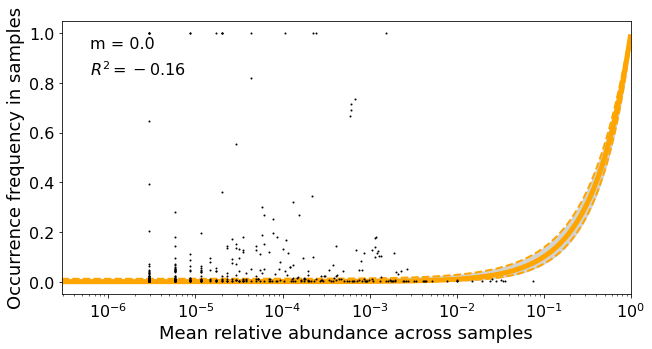

In [28]:
#neufit_plot(occurr_freqs, beta_fit, n_samples, n_reads, r_square)

#neufit_plot(combo, beta_fit, n_samples, n_reads, r_square, True, 'experimental_outputs/Hutch_combined_salivaSource_RS210_neufit.png')

#neufit_plot(combo, beta_fit, n_samples, n_reads, r_square, True, 'experimental_outputs/Hutch_combined_AGP_mouth_Wol2_neufit.png')

neufit_plot(combo, beta_fit, n_samples, n_reads, r_square, True, 'experimental_outputs/Hutch_combined_AGP_fecal_Wol2_neufit.png')


In [62]:
beta_fit, r_square = neufit_calc(occurr_freqs, n_reads, n_samples)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 1995
    # variables        = 1
    chi-square         = 3.17568024
    reduced chi-square = 0.00159262
    Akaike info crit   = -12851.5406
    Bayesian info crit = -12845.9422
[[Variables]]
    N:  5000 (fixed)
    m:  0.25787271 +/- 0.01116750 (4.33%) (init = 0.5)
R^2 = 0.98


In [63]:
neufit_plot(occurr_freqs, beta_fit, n_samples, n_reads, r_square, True, 'experimental_outputs/Hutch_combined_RS210_neufit.png')

<ipython-input-10-d356591f1df0>:51: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


In [64]:
sbeta_fit, sr_square = neufit_calc(soccurr_freqs, sn_reads, sn_samples)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 3781
    # variables        = 1
    chi-square         = 123.168727
    reduced chi-square = 0.03258432
    Akaike info crit   = -12944.8572
    Bayesian info crit = -12938.6195
[[Variables]]
    N:  60000 (fixed)
    m:  0.25121794 +/- 0.01128975 (4.49%) (init = 0.5)
R^2 = 0.60


In [65]:
neufit_plot(soccurr_freqs, sbeta_fit, sn_samples, sn_reads, sr_square, True)


<ipython-input-10-d356591f1df0>:51: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


In [20]:
e = [0,0,0,0,0,0,0,0]
for i in occurr_freqs['mean_abundance']:
    if i < 0.000001: #e-07
        e[7] +=1
    elif i < 0.00001: #e-06
        e[6] +=1
    elif i < 0.0001: #e-05
        e[5] +=1
    elif i < 0.001: #e-04
        e[4] +=1
    elif i < 0.01: #e-03
        e[3] +=1
    elif i < 0.1: #e-02
        e[2] +=1
    elif i < 1: #e-01
        e[1] +=1
    elif i < 10: #10
        e[0] +=1
print(e)
print(sum(e))

e_avg = []
for i in e:
    perc = (i/sum(e))*100
    e_avg.append(perc)
print(e_avg)

[0, 0, 0, 189, 49, 278, 857, 600]
1973
[0.0, 0.0, 0.0, 9.579320831221489, 2.4835276229092753, 14.09021794221997, 43.4363912823112, 30.410542321338063]


## Selection

#### Re-shape data to be selection model input & run on Barnacle

In [53]:
#Export Mean Abudnace List
NP_mean_abundance_list = np.array(NP_occurr_freqs['mean_abundance'].tolist())
NP_mean_abundance_list.tofile('selection_inputs/' + NP_mean_abundance_list_fn + '.csv', sep = ',')

#Print selection input parameters
print('Output file name:', NP_mean_abundance_list_fn)
print()
print('Number of hosts:', NP_n_samples)
print('Number of microbial taxa:', len(NP_occurr_freqs))
print('Number of microbes within a host (rarefaction level):', NP_rarefaction_level) 


Output file name: HutchBE_q14598_species_2022-12-28_14-30-07_149_858_25000

Number of hosts: 149
Number of microbial taxa: 858
Number of microbes within a host (rarefaction level): 25000


#### Plot the output of the selection model following Barnacle Run

#### Neutral

##### Experimental m value

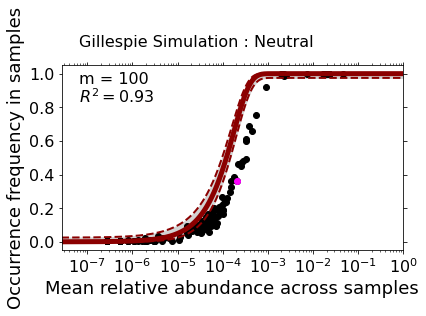

In [54]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_m100.npz', True)


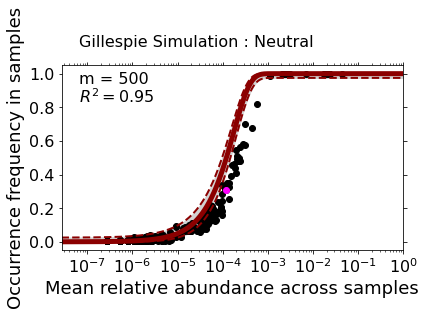

In [55]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_m500.npz', True)


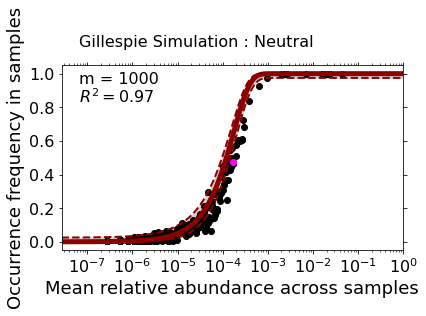

In [56]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_m1000.npz', True)


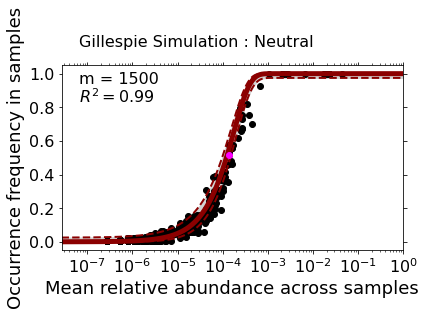

In [57]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_m1500.npz', True)


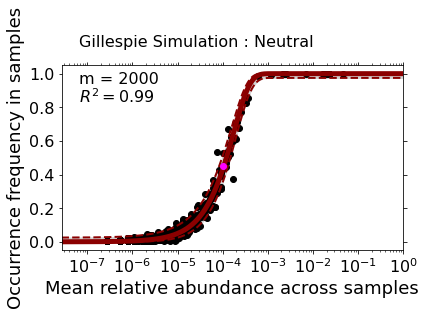

In [58]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_m2000.npz', True)


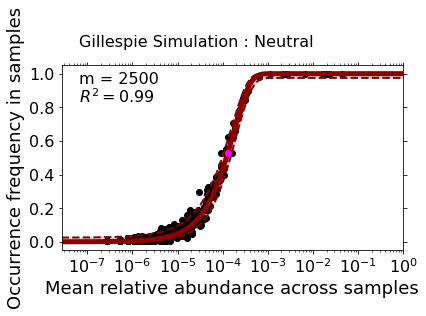

In [59]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_m2500.npz', True)


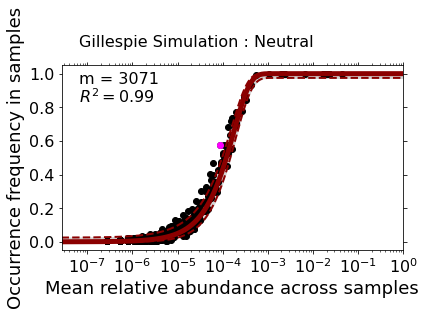

In [65]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_1_1_m3071.npz', True)


##### Shifting birth/death rates

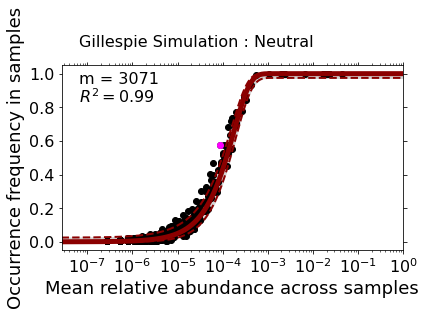

In [20]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_1_1_m3071.npz', True)


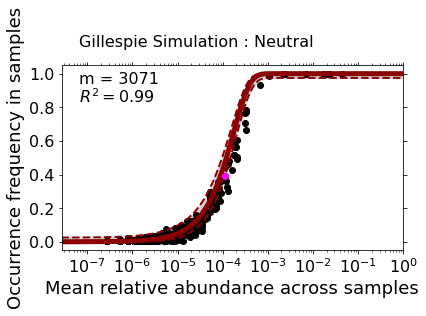

In [21]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_2_2_m3071.npz', True)
  

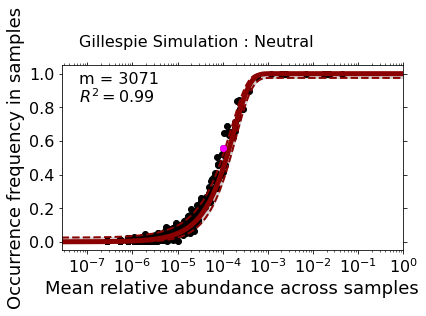

In [22]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_1_2_m3071.npz', True)


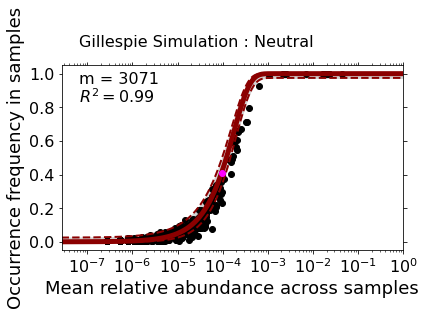

In [69]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_2_1_m3071.npz', True)


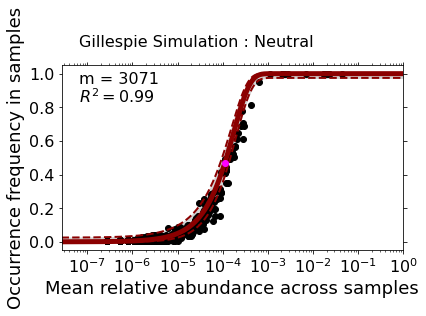

In [8]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_growthArray_2Array_deathArray_1Array__m3071.npz', True)
#This is the same as above with new syntax --- Kit wanted to check that it works 

###### m value = 15000 (will likely not use these)

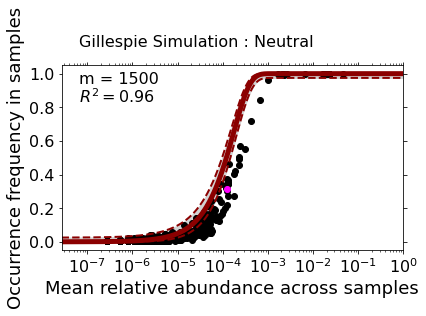

In [63]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_2_1_m1500.npz', True)


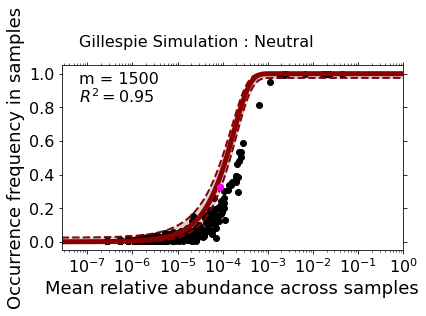

In [64]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_neutral_1array_2_2_m1500.npz', True)


#### Non-Neutral

##### Experimental m value

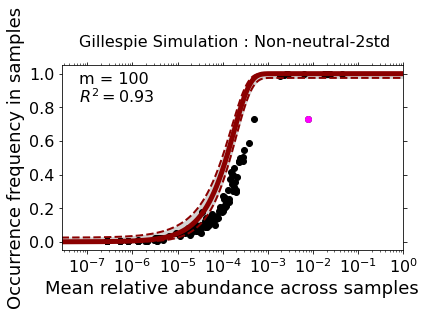

In [60]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_m100.npz', True)


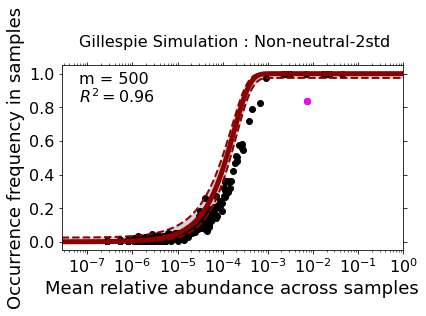

In [61]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_m500.npz', True)


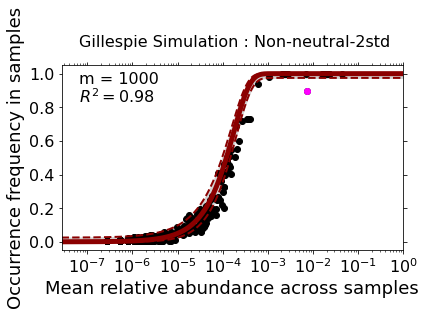

In [62]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_m1000.npz', True)


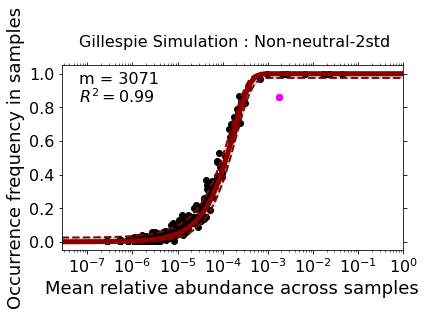

In [66]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_1_1_m3071.npz', True)


##### Shifting birth/death rates

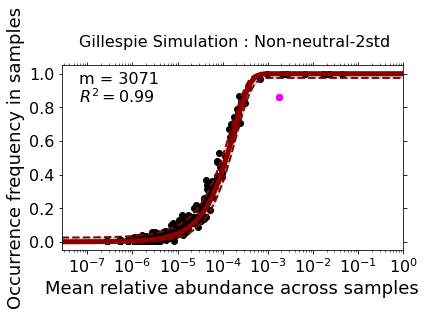

In [71]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_1_1_m3071.npz', True)


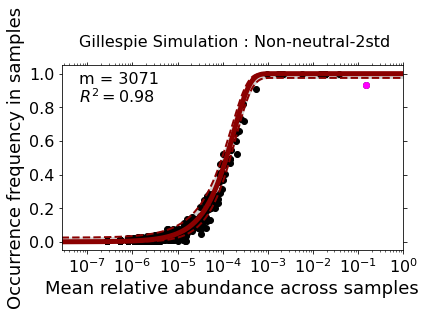

In [74]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_2_2_m3071.npz', True)
 

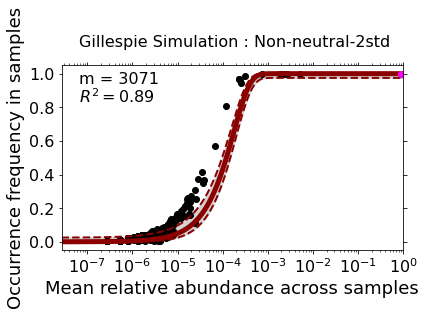

In [72]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_1_2_m3071.npz', True)


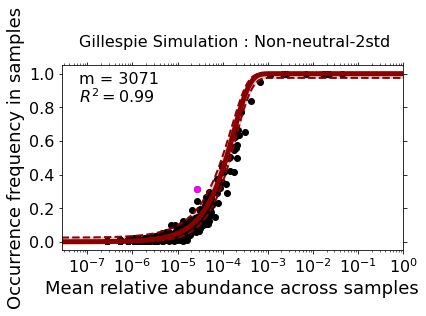

In [73]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non-neutral-2std_1array_2_1_m3071.npz', True)


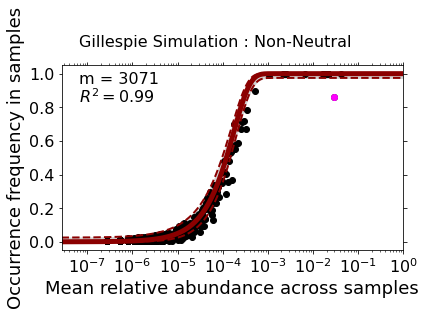

In [25]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non_neutral_growthHP2.2_deathHP1.8_growthArray_2Array_deathArray_2Array__m3071.npz', True)


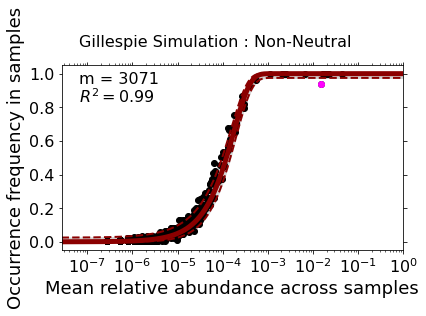

In [24]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non_neutral_growthHP1.2_deathHP1.8_growthArray_1Array_deathArray_2Array__m3071.npz', True)


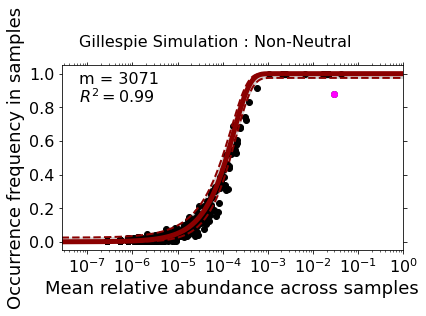

In [23]:
selection_plot('HutchBE_q14598_species_2022-12-15_14-37-43_149_852_25000_non_neutral_growthHP2.2_deathHP0.8_growthArray_2Array_deathArray_1Array__m3071.npz', True)
